# Multi-output Gaussian Processes for Dose Response Predictions

In [154]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

plt.close('all')

#_FOLDER = "/home/ac1jjgg/Dataset_BRAF_NoReplica_ANOVA_Features/GDSC1/"
#_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/Dataset_BRAF_NoReplica_ANOVA_Features/GDSC1/"
_FOLDER = "../Dataset_BRAF_NoReplica_ANOVA_Features/GDSC1/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys
sys.path.append('..')

warnings.filterwarnings("ignore")
#os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'
"Best Model Drug1061: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 1.0000 -k 2 -w 1.0000 -r 1014 -p 505 -d 1061 -e 0"
"Best Model Drug1373: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 1.0000 -k 2 -w 1.0000 -r 1013 -p 221 -d 1373 -e 0"
"Best Model Drug1036: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1018 -p 946 -d 1036 -e 0"

'Best Model Drug1036: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1018 -p 946 -d 1036 -e 0'

In [155]:
print("TODO: check that Niter is actually used!!!!")
class commandLine:
    def __init__(self):
        #opts, args = getopt.getopt(sys.argv[1:], 'i:s:k:w:r:p:d:e:')
        # opts = dict(opts)
        # print(opts)
        "TODO: check that Niter is actually used!!!!"
        self.N_iter = 30    #number of iterations
        self.which_seed = 1018    #change seed to initialise the hyper-parameters
        self.rank = 2
        self.scale = 1.0
        self.weight = 0.01
        self.bash = "946"
        self.drug_name = "1036"
        self.feature = 2

#         for op, arg in opts:
#             # print(op,arg)
#             if op == '-i':
#                 self.N_iter = arg
#             if op == '-r':  # (r)and seed
#                 self.which_seed = arg
#             if op == '-k':  # ran(k)
#                 self.rank = arg
#             if op == '-s':  # (r)and seed
#                 self.scale = arg
#             if op == '-p':  # (p)ython bash
#                 self.bash = arg
#             if op == '-w':
#                 self.weight = arg
#             if op == '-d':
#                 self.drug_name = arg
#             if op == '-e':
#                 self.feature = arg

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

TODO: check that Niter is actually used!!!!


''

In [156]:
"#Bear in mind that the drugs 1061 and 1036 have 9 concentrations, i.e., d1, d2, d3, d4, d5, d6, d7, d8 and d9 "
"#but the drugs 1371 and 1373 have 5 concentrations, i.e, d1, d3, d5, d7 and d9"
"#Drugs 1036 and 1371 are the same one, but the former has 9 concentrations and the latter 5 concentrations"

dconcentr = {"1061": "9conc","1036": "9conc","1373": "5conc","1371": "5conc"}
feat_for_drug = {"1061": "2-fold","1036": "2-fold","1373": "4-fold","1371": "4-fold"}
name_for_KLrelevance = 'GDSC1_melanoma_BRAF_'+dconcentr[config.drug_name]+'_noreps_v3.csv'
name_ANOVA_feat_file = 'GDSC1_BRAFmelanoma_ANOVAfeatures_'+feat_for_drug[config.drug_name]+'.csv'

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
df_ANOVA_feat_Names = pd.read_csv(_FOLDER + name_ANOVA_feat_file)  # Contain Feature Names used by ANOVA
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_No_MolecForm = df_train_No_MolecForm[(df_train_No_MolecForm["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

# the column index 29 for Drug 1061 the input features start
# but column index 21 is for Drug 1373
if config.drug_name == "1061" or config.drug_name == "1036":
    Dnorm_cell = 9
    start_pos_features = 29
elif config.drug_name == "1373" or config.drug_name == "1371":
    Dnorm_cell = 5
    start_pos_features = 21

print(df_train_No_MolecForm.columns[start_pos_features])

ARID1A_mut


In [157]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Scale the Genomic features to be between 0 and 1"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we extract from the dataframe the D outputs related to each dose concentration"
"Below we select 9 concentration since GDSC1 has that number for Drugs 1036 and 1061"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, Dnorm_cell+1):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)

(40, 1)
Ytrain size:  (40, 9)


In [158]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Since we fitted the dose response curves with a Sigmoid4_parameters function"
"We extract the optimal coefficients in order to reproduce such a Sigmoid4_parameters fitting"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):  #here there are four params for sigmoid4
    params_4_sig_train = np.concatenate(
        (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)


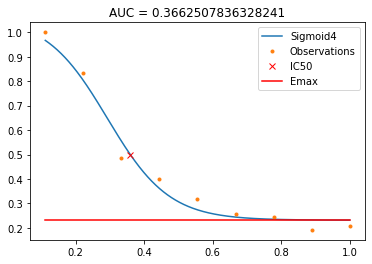

In [181]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this sections we will extract the summary metrics AUC, Emax and IC50 from the Sigmoid4_parameters functions"
"These metrics are used as the references to compute the error metrics"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn import metrics
from importlib import reload
import Utils_SummaryMetrics_KLRelevance
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(Utils_SummaryMetrics_KLRelevance)

"Be careful that x starts from 0.111111 for 9 or 5 drug concentrations in GDSC1 dataset"
"but x starts from 0.142857143 for the case of 7 drug concentrations in GDSC2 dataset"
"The function Get_IC50_AUC_Emax is implemented in Utils_SummaryMetrics_KLRelevance.py to extract the summary metrics"
x_lin = np.linspace(0.111111, 1, 1000)
x_real_dose = np.linspace(0.111111, 1, Dnorm_cell)  #Here is Dnorm_cell due to using GDSC1 that has 9 or 5 doses
Ydose50,Ydose_res,IC50,AUC,Emax = MyUtils.Get_IC50_AUC_Emax(params_4_sig_train,x_lin,x_real_dose)

def my_plot(posy,fig_num,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug):
    plt.figure(fig_num)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    plt.legend(['Sigmoid4','Observations','IC50','Emax'])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we can visualise the values of the GDSC1 dataset with the fitting of Sigmoid4_parameters function"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
posy = 0   #select the location you want to plot, do not exceed the Ytrain length
my_plot(posy,0,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug)

In [160]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Organize summary metrics with proper dimensionality"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
Name_Features_Melanoma = df_train_No_MolecForm.columns[start_pos_features:]
Xall = X_train_features.copy()
Yall = y_train_drug.copy()

print("Sanity check to the same features Evelyin Provided")
print(df_ANOVA_feat_Names["feature"].values[start_pos_features:]==Name_Features_Melanoma)

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

Sanity check to the same features Evelyin Provided
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AUC train size: (40, 1)
IC50 train size: (40, 1)
Emax train size: (40, 1)
X all data size: (40, 24)
Y all data size: (40, 9)


In [161]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn.model_selection import KFold, cross_val_score
Ndata = Xall.shape[0]
Xind = np.arange(Ndata)
nsplits = 20 #Ndata
k_fold = KFold(n_splits=nsplits)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell

In [179]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"MOGP model Training process"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell
list_folds = list(k_fold.split(Xall))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The for loop below runs the cross-validation process for the MOGP model"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
for Nfold in range(0,nsplits+1):
    model = []
    "The first if below is for the cross-val"
    "Then the else is for using all data to save the model trained over all data"
    if Nfold<nsplits:
        train_ind, test_ind = list_folds[Nfold]
        print(f"{test_ind} to Val in IC50")

        Xval_aux = Xall[test_ind].copy()
        Ylabel_val = np.array([i * np.ones(Xval_aux.shape[0]) for i in range(Ntasks)]).flatten()[:, None]

        Xval = np.concatenate((np.tile(Xval_aux,(Ntasks,1)), Ylabel_val), 1)

        Xtrain_aux = Xall[train_ind].copy()
        Ylabel_train = np.array([i * np.ones(Xtrain_aux.shape[0]) for i in range(Ntasks)]).flatten()[:, None]
        Xtrain = np.concatenate((np.tile(Xtrain_aux, (Ntasks, 1)), Ylabel_train), 1)

        Yval = Yall[test_ind].T.flatten().copy()[:,None]
        Ytrain = Yall[train_ind].T.flatten().copy()[:,None]

        Emax_val = Emax_all[test_ind].copy()
        AUC_val = AUC_all[test_ind].copy()
        IC50_val = IC50_all[test_ind].copy()

    else:
        print(f"Train ovell all Data")
        _, test_ind = list_folds[0] #Just assigning by defaul fold0 as the test (of course not to report it as a result)
        Xval_aux = Xall[test_ind].copy()
        Ylabel_val = np.array([i * np.ones(Xval_aux.shape[0]) for i in range(Ntasks)]).flatten()[:, None]

        Xval = np.concatenate((np.tile(Xval_aux, (Ntasks, 1)), Ylabel_val), 1)

        Xtrain_aux = Xall.copy()
        Ylabel_train = np.array([i * np.ones(Xtrain_aux.shape[0]) for i in range(Ntasks)]).flatten()[:, None]
        Xtrain = np.concatenate((np.tile(Xtrain_aux, (Ntasks, 1)), Ylabel_train), 1)

        Yval = Yall[test_ind].T.flatten().copy()[:,None]
        Ytrain = Yall.T.flatten().copy()[:,None]

        Emax_val = Emax_all[test_ind].copy()
        AUC_val = AUC_all[test_ind].copy()
        IC50_val = IC50_all[test_ind].copy()
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import GPy
    # os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean_all = np.zeros_like(Yval)
    models_outs = []

    rank = int(config.rank)  # Rank for the MultitaskKernel
    "Below we substract one due to being the label associated to the output"
    Dim = Xtrain.shape[1]-1
    myseed = int(config.which_seed)
    np.random.seed(myseed)
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Product Kernels. Below we use the locations:"
    "Kernel1 accounts for locations 0:11 for Mutation"
    "Kernel2 accounts for locations 11:end for PANCAN"
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    split_dim = 2
    AddKern_loc = [11, Dim]
    mykern = GPy.kern.RBF(AddKern_loc[0], active_dims=list(np.arange(0, AddKern_loc[0])))
    print(list(np.arange(0, AddKern_loc[0])))
    for i in range(1, split_dim):
        mykern = mykern * GPy.kern.RBF(AddKern_loc[i]-AddKern_loc[i-1],active_dims=list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))
        print(list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the kernel hyper-parameters"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    mykern.rbf.lengthscale = float(config.scale)* np.sqrt(Dim) * np.random.rand()
    mykern.rbf.variance.fix()
    for i in range(1,split_dim):
        eval("mykern.rbf_"+str(i)+".lengthscale.setfield(float(config.scale)* np.sqrt(Dim) * np.random.rand(), np.float64)")
        eval("mykern.rbf_" + str(i) + ".variance.fix()")

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Create the coregionalization kernel for the MOGP model and create the MOGPRegression model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    kern = mykern ** GPy.kern.Coregionalize(1, output_dim=Ntasks,rank=rank)
    model = GPy.models.GPRegression(Xtrain, Ytrain, kern)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the linear combination coefficients for coregionalization matrix of MOGP"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Init_Ws = float(config.weight) * np.random.randn(Ntasks,rank)
    model.kern.coregion.W = Init_Ws
    #model.optimize(optimizer='lbfgsb',messages=True,max_iters=int(config.N_iter))
    #model.optimize()
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # Here we load the model bash*:
    m_trained = str(config.bash)
    print("loading model ", m_trained)
    #model[:] = np.load('/home/ac1jjgg/MOGP_GPy/Codes_for_GDSC1_ANOVA/Best_Model_Drug'+config.drug_name+'_MelanomaGDSC1_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    model[:] = np.load('./Best_Model_Drug' + config.drug_name + '_MelanomaGDSC1_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    m_pred, v_pred = model.predict(Xval, full_cov=False)
    Yval_curve = Yval.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    m_pred_curve = m_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    v_pred_curve = v_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Here we extract the summary metrics AUC, Emax and IC50 from the MOGP curve predictions"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    x_dose = np.linspace(0.111111, 1.0, Ntasks)
    x_dose_new = np.linspace(0.111111, 1.0, 1000)  #This new lispace is for the pchip interpolation
    Y_pred_interp_all,std_upper_interp_all,std_lower_interp_all,_, Ydose50_pred, IC50_pred, AUC_pred, Emax_pred = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose =x_dose,x_dose_new = x_dose_new,m_pred_curve=m_pred_curve, v_pred=v_pred)

    Ydose50_pred = np.array(Ydose50_pred)
    IC50_pred = np.array(IC50_pred)[:,None]
    AUC_pred = np.array(AUC_pred)[:, None]
    Emax_pred = np.array(Emax_pred)[:, None]
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Compute different error metrics!"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_NMLL = -np.mean(model.log_predictive_density(Xval, Yval))  #Negative Log Predictive Density (NLPD)
    Emax_abs = np.mean(np.abs(Emax_val - Emax_pred))
    AUC_abs = np.mean(np.abs(AUC_val - AUC_pred))
    IC50_MSE = np.mean((IC50_val - IC50_pred) ** 2)
    MSE_curves = np.mean((m_pred_curve - Yval_curve) ** 2, 1)
    AllPred_MSE = np.mean((m_pred_curve - Yval_curve) ** 2)

    Med_MSE = np.median(MSE_curves)
    Mean_MSE = np.mean(MSE_curves)

    if Nfold < nsplits:
        print(f'\nError Metrics fold {Nfold}:')
        print("\nNegLPD Val", Val_NMLL)
        print("IC50 MSE:", IC50_MSE)
        print("AUC MAE:", AUC_abs)
        print("Emax MAE:", Emax_abs)
        print("Med_MSE:", Med_MSE)
        print("Mean_MSE:", Mean_MSE)
        print("All Predictions MSE:", AllPred_MSE)

        NegMLL_AllFolds.append(Val_NMLL.copy())
        Emax_abs_AllFolds.append(Emax_abs.copy())
        AUC_abs_AllFolds.append(AUC_abs.copy())
        IC50_MSE_AllFolds.append(IC50_MSE.copy())
        Med_MSE_AllFolds.append(Med_MSE.copy())
        Mean_MSE_AllFolds.append(Mean_MSE.copy())
        AllPred_MSE_AllFolds.append(AllPred_MSE.copy())

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

[0 1] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 0:

NegLPD Val 0.4508376841579971
IC50 MSE: 0.6078293579329678
AUC MAE: 0.19607374118774165
Emax MAE: 0.16059862000022734
Med_MSE: 0.0723794975896675
Mean_MSE: 0.0723794975896675
All Predictions MSE: 0.0723794975896675
[2 3] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 1:

NegLPD Val 1.0628466794889202
IC50 MSE: 0.7359042462949372
AUC MAE: 0.4108794265888157
Emax MAE: 0.5150502374300431
Med_MSE: 0.32506275074416635
Mean_MSE: 0.32506275074416635
All Predictions MSE: 0.32506275074416635
[4 5] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 2:

NegLPD Val -0.22477334352346773
IC50 MSE: 0.1908787632639253
AUC MAE: 0.0895706649101686
Emax MAE: 0.234665204749

In [180]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Cross validation performance of the current seed"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print('Metrics of Seed performance along K-folds (mean +/- std):\n')
print(f'dose response curve MSE: {np.mean(AllPred_MSE_AllFolds)} +/- {np.std(AllPred_MSE_AllFolds)}')
print(f'NegLog Predictive Density: {np.mean(NegMLL_AllFolds)} +/- {np.std(NegMLL_AllFolds)}')
print(f'IC50 MSE: {np.mean(IC50_MSE_AllFolds)} +/- {np.std(IC50_MSE_AllFolds)}')
print(f'AUC MAE: {np.mean(AUC_abs_AllFolds)} +/- {np.std(AUC_abs_AllFolds)}')
print(f'Emax MAE: {np.mean(Emax_abs_AllFolds)} +/- {np.std(Emax_abs_AllFolds)}')

Metrics of Seed performance along K-folds (mean +/- std):

dose response curve MSE: 0.09890452302286187 +/- 0.10212468855804228
NegLog Predictive Density: 0.1702506861092739 +/- 0.7642101297150027
IC50 MSE: 0.32785337163389927 +/- 0.30482092447514886
AUC MAE: 0.19411497851573462 +/- 0.12222080463413161
Emax MAE: 0.25474276565271287 +/- 0.17267962741933504


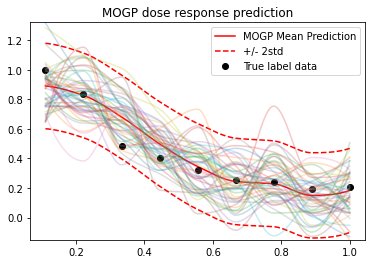

In [182]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Make predictions with the model and plot one of the dose response curves"
"We plot the mean +/- 2std of the MOGP predicitons"
"The multiple coloured functions are samples from predictive posterior distribution"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
N_Samples = 50
Ypred_interp,StdPred_upper_interp,StdPred_lower_interp,Ypred_MOGP_Samples,_,_,_,_ = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose,x_dose_new = x_dose_new,model=model,Xval=Xtrain,MOGPsamples=N_Samples)

idx = 0
#for idx in range(20):
plt.figure(idx)
plt.ylim([-0.15,1.32])
plt.plot(x_dose_new,Ypred_interp[idx],'r')
plt.plot(x_dose_new,StdPred_upper_interp[idx],'r--')
plt.plot(x_dose_new,StdPred_lower_interp[idx],'r--')
plt.plot(x_dose, Yall[idx], 'ko')
plt.title('MOGP dose response prediction')
plt.legend(["MOGP Mean Prediction","+/- 2std","_nolegend","True label data"])
for i in range(N_Samples):
    plt.plot(x_dose_new, Ypred_MOGP_Samples[idx][i],alpha=0.25)


In [176]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here We run the KLRelevance algorith over an specific p-th feature"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from importlib import reload
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)
KLRel = np.zeros((Xtrain.shape[0]//Dnorm_cell,Xtrain.shape[1]-1))
FileName = "Drug"+config.drug_name+"_MelanomaGDSC1_ANOVA_ExactMOGP_m"+m_trained
for pth_feat in range(24):
    relevance = MyUtils.KLRelevance_MOGP_GPy(train_x=Xtrain, model=model, delta=1.0e-6,
                                                       which_p=int(pth_feat), diag=False, Use_Cholesky=True,
                                                       ToSave=False, FileName=FileName)
    KLRel[:,pth_feat] = relevance[:,pth_feat].copy()

Mean_KLRel = np.mean(KLRel,0)[None,:]
Norm_Mean_KLRel = Mean_KLRel/np.max(Mean_KLRel)
Norm_Mean_KLRel_sorted = np.sort(Norm_Mean_KLRel).flatten()[::-1]
Names_features_sorted = Name_Features_Melanoma[ind_sort].flatten()[::-1]

Analysing Feature 0 of 24...
Analysing Feature 1 of 24...
Analysing Feature 2 of 24...
Analysing Feature 3 of 24...
Analysing Feature 4 of 24...
Analysing Feature 5 of 24...
Analysing Feature 6 of 24...
Analysing Feature 7 of 24...
Analysing Feature 8 of 24...
Analysing Feature 9 of 24...
Analysing Feature 10 of 24...
Analysing Feature 11 of 24...
Analysing Feature 12 of 24...
Analysing Feature 13 of 24...
Analysing Feature 14 of 24...
Analysing Feature 15 of 24...
Analysing Feature 16 of 24...
Analysing Feature 17 of 24...
Analysing Feature 18 of 24...
Analysing Feature 19 of 24...
Analysing Feature 20 of 24...
Analysing Feature 21 of 24...
Analysing Feature 22 of 24...
Analysing Feature 23 of 24...


In [177]:
df_KLRel_GDSC1 = pd.DataFrame({'rank': Norm_Mean_KLRel_sorted,'feature':Names_features_sorted})
df_KLRel_GDSC1

,rank,feature
0,1.000000,loss.cnaSKCM23
1,0.832888,loss.cnaSKCM22
2,0.742242,EZH2_mut
3,0.678015,PTEN_mut
4,0.639183,loss.cnaSKCM28
5,0.632634,BRAF_mut
6,0.596045,loss.cnaSKCM24..loss.cnaSKCM25
7,0.558467,loss.cnaSKCM3
8,0.500565,gain.cnaSKCM21..FOXP1.MITF.
9,0.471784,MECOM_mut
